In [1]:
# In this section, I will investigate the behaviour of a time series with Markov switching regimes.
# In particular, the time series is formulated by (stationary) AR(1) process, but the intercept is allowed to switch
# between a(s1) and a(s2) (assume only 2 regimes exist).
# Since we only focus on the Markov switching regime process, the model is allowed to be homoskedastic.
# The model would be:
# y(t) = a(s(t)) + b*y(t-1) + u(s(t)), where u(s(t)) is normally distributed with mean 0 and variance sig(s(t))^2.
# s(t) = 0 or 1, implying 2 regimes we're considering.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import norm

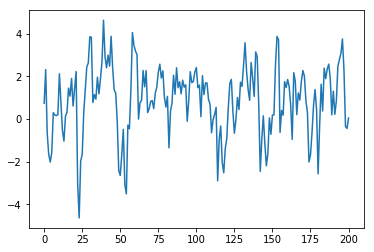

In [6]:
# As usual, I, first, simulate the time series with Markov switching regime process, then, use the synthesis data to estimate.

# First: simulation
y0 = np.random.normal(0,1)

# To create the switching mechanism, the transition probability matrix is needed. A constrain of this matrix is that, it is 
# "irreducible". For the 2-state Markov chain, it means that each diagonal element lies between 0 and 1
p11 = 0.7
p22 = 0.4

# Then, the transition probability matrix is constructed as follow (denoted by P)
P = np.array([[p11, 1-p11],[1-p22, p22]])

# The intercepts of 2 regimes
a0 = 0.7
a1 = -0.5
a = np.array([a0, a1])

# AR process parameter and the variance of the series among 2 regimes.
b = 0.6
sig0 = 0.8
sig1 = 1.4
sig = np.array([sig0, sig1])

# The first regime has higher intercept and smaller variance, it represents for the stable regime in the economy.
# The second is constructed in opposite, thus it denotes the recessive period in the economy.

# Firstly, choose an initial state
s0 = np.random.randint(0,2)
s = np.zeros((300,1))
s[0] = s0

# Draw the initial value of y in an (seemingly) uninformative prior
y0 = np.random.normal(0,50)
y = np.zeros((300,1))
y[0] = y0

for t in range(1,len(y)):
    # For each t, consider the change or not
    test = np.random.uniform(0,1)
    if test > P[int(s[t-1]),int(s[t-1])]:
        s[t] = 1-s[t-1]
    else:
        s[t] = s[t-1]
    ut = np.random.normal(0,sig[int(s[t])])
    y[t] = a[int(s[t])] + b*y[t-1] + ut
    
# Cut off the first observations of y
y = y[99:]

# Visualize y
_ = plt.figure
_ = plt.plot(range(len(y)), y)
plt.show()

In [7]:
# Now, we try to estimate this model using Maximum likelihood and EM algorithm.
# For the likelihood function, please refer to Time Series Analysis textbook of Hamilton, chapter 22, pp.688, and Wong and Li (2000)
# In this kernel, we're gonna build some ingredient functions for EM algorithm

def con_prob_state(y,a,b,sig,pi,K):
    prob_s = np.zeros(K)
    f = 0
    for j in range(K):
        f += pi[j]/(np.sqrt(2*np.pi)*sig[j])*np.exp(-(y[0]-a[j]-b[j]*y[1])**2/(2*sig[j]**2))
    for j in range(K):
        prob_s[j] = (pi[j]*(1/sig[j])*norm.pdf((y[0]-a[j]-b[j]*y[1])/sig[j]))/f
    return prob_s

def pi(prob_s,T):
    if prob_s.shape[0] == K:
        prob_s = np.transpose(prob_s)
    else:
        prob_s = prob_s
    pi = prob_s.sum(axis = 0)/T
    return pi

def sig(y,mu,b,prob_s,K):
    if y.shape[0] == 1:
        y = np.transpose(y)
    else:
        y = y
    if prob_s.shape[0] == K:
        prob_s = np.transpose(prob_s)
    else:
        prob_s = prob_s
    
    de = prob_s.sum(axis = 0)
    num = np.zeros((1,K))
    for k in range(K):
        num[0][k] = np.multiply(prob_s[:,k], ((y[p:]-mu[k]-b[k]*y[:len(y)-p])**2).ravel()).sum()
    sig = np.sqrt(np.divide(num, de))
    return sig

def AR_coef(pk,y,prob_s):
    # Refer to Wong and Li (2000), we try to solve a system of linear equations
    # To this end, we try to convert it into the matrix form
    if y.shape[0] == 1:
        y = np.transpose(y)
    else:
        y = y
    if prob_s.shape[0] == 1:
        prob_s = np.transpose(prob_s)
    else:
        prob_s = prob_s
    u_i = np.zeros((pk,1))
    
    lhs = np.zeros((pk,1))
    for t in range(p,len(y)):
        for i in range(pk):
            if i == 0:
                lhs[i] += prob_s[t-p]*y[t]
            else:
                lhs[i] += prob_s[t-p]*y[t]*y[t-i]
    
    rhs = np.zeros((pk,pk))
    for t in range(p,len(y)):
        for i in range(pk):
            for j in range(pk):
                if i == 0:
                    if j == 0:
                        rhs[i,j] += prob_s[t-p]
                    else:
                        rhs[i,j] += prob_s[t-p]*y[t-j]
                else:
                    if j == 0:
                        rhs[i,j] += prob_s[t-p]*y[t-i]
                    else:
                        rhs[i,j] += prob_s[t-p]*y[t-j]*y[t-i]
    AR_coef = inv(rhs).dot(lhs)
    return AR_coef

def likelihood(y,p,a,b,sig,pi,K):
    ft = np.zeros((len(y)-p,1))
    for t in range(len(y)-p):
        for j in range(K):
            ft[t] += pi[j]/(np.sqrt(2*np.pi)*sig[j])*np.exp(-(y[t+1]-a[j]-b[j]*y[t])**2/(2*sig[j]**2))
    log_likelihood = np.log(ft).sum()
    return log_likelihood

In [8]:
# Now, perform the EM algorithm
# State the initial parameters
a_init = np.array([[0.5],[-0.5]])
b_init = np.array([[1],[0]])
sig_init = np.array([[0.2],[0.2]])
pi_init_0 = np.random.uniform(0,1)
pi_init_1 = 1-pi_init_0
pi_init = np.array([[pi_init_0],[pi_init_1]])

# Number of regimes is K = 2
K = 2

# Assume 1 lag
p = 1

# Now, implement the iterations
# Allow, in maximum, 1000 iterations
max_iter = 1000

# Matrices to store the values
a_final = a_init
b_final = b_init
sig_final = sig_init
pi_final = pi_init

for i in range(max_iter):
    
    # The E-step: compute the conditional probability of each state
    prob_s = np.zeros((len(y)-p,K))
    for t in range(p,len(y)):
        y_used = np.array([y[t], y[t-1]])
        prob_s[t-p] = con_prob_state(y_used,a_final,b_final,sig_final,pi_final,K)
    
    # The M-step: update the necessary parameters
    pi_est = pi(prob_s,len(y)-p)
    aux_var = np.zeros((K,2))
    pk = np.array([2,2])
    for k in range(K):
        aux_var[k] = AR_coef(pk[k],y[p:],prob_s[:,k]).ravel()
    b_est = aux_var[:,1]
    a_est = aux_var[:,0]
    sig_est = sig(y,a_est,b_est,prob_s,K).ravel()
    
    # Terminate the algorithm if it converges
    log_old = likelihood(y,p,a_final,b_final,sig_final,pi_final,2)
    log_new = likelihood(y,p,a_est,b_est,sig_est,pi_est,2)
    
    if np.absolute(log_old-log_new) < 0.0000000001:
        # After perform one iteration, we print out the result
        print ("Iteration: " + str(i+1))
        print ("a_s0 = " + str(a_est[0]) + ", a_s1 = " + str(a_est[1]))
        print ("b_s0 = " + str(b_est[0]) + ", b_s1 = " + str(b_est[1]))
        print ("sig_s0 = " + str(sig_est[0]) + ", sig_s1 = " + str(sig_est[1]))
        print ("phi_s0 = " + str(pi_est[0]) + ", phi_s1 = " + str(pi_est[1]))
        break
    a_final = a_est
    b_final = b_est
    sig_final = sig_est
    pi_final = pi_est
    if i == 999:
        print ("The convergence has failed within 1000 iterations!!!")
        print ("a_s0 = " + str(a_est[0]) + ", a_s1 = " + str(a_est[1]))
        print ("b_s0 = " + str(b_est[0]) + ", b_s1 = " + str(b_est[1]))
        print ("sig_s0 = " + str(sig_est[0]) + ", sig_s1 = " + str(sig_est[1]))
        print ("phi_s0 = " + str(pi_est[0]) + ", phi_s1 = " + str(pi_est[1]))

Iteration: 886
a_s0 = 0.36564568156828225, a_s1 = 0.24371323526209276
b_s0 = 0.6042173711907326, b_s1 = 0.6832136520451656
sig_s0 = 0.8166952255750723, sig_s1 = 1.5844393933003056
phi_s0 = 0.5505605719208383, phi_s1 = 0.4494394280791618


In [ ]:
# The estimation is fairly good. The slopes are estimated well (close to the true value, 0.6 in both regimes). The same result
# could be found on the variances in two regimes 0.8167 (true value: 0.8) and 1.5844 (true value: 1.4). However, the estimated
# intercepts fail since they are far different from the true values and could even not reflect their opposite signs.

# Please notice that: the performance of EM algorithm depends severely on the choice of initial values!!!